In [1]:
from binance.client import Client
import config
import pandas as pd

In [2]:
exchange = Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)

In [3]:
def getData(symbol,time,client):
    """
    1504541580000, // UTC timestamp in milliseconds, integer
    4235.4,        // (O)pen price, float
    4240.6,        // (H)ighest price, float
    4230.0,        // (L)owest price, float
    4230.7,        // (C)losing price, float
    37.72941911    // (V)olume float (usually in terms of the base currency, the exchanges docstring may list whether quote or base units are used)
    """
    klines = client.get_historical_klines(symbol=symbol, interval=time)

    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df = pd.DataFrame(klines, columns=columns)

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('America/Chicago')
    

    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    #df.set_index('Date', inplace=True)
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    return df

In [4]:
def calculate_macd(data, **params):
    """
    Calculates the MACD line, signal line, and zero line for a given DataFrame of stock data.
    :param data: DataFrame containing stock data with at least a 'Close' column and a DatetimeIndex.
    :param EMA Long Period: The period length for the long EMA. Default is 26.
    :param EMA Short Period: The period length for the short EMA. Default is 12.
    :param Signal Line Period: The period length for the signal line. Default is 9.
    :return: DataFrame containing the MACD line, signal line, and zero line as columns, with the same index as the input DataFrame.
    """
    ema_long = data['Close'].ewm(span=params['EMA Long Period'], adjust=False).mean()
    ema_short = data['Close'].ewm(span=params['EMA Short Period'], adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=params['Signal Line Period'], adjust=False).mean()
    zero_line = pd.Series(0, index=data.index)
    macd_df = pd.concat([macd_line, signal_line, zero_line], axis=1)
    macd_df.columns = ['MACD_line', 'Signal_line', 'Zero_line']
    return macd_df


In [5]:
class MyStrategy:
    
    def generate_signals_backtest(self,data,user_input,**params):
       
        # data['Signal'] = data['Signal'].astype("float")
        if user_input == 'MACD':
            signals = self.MACD_strategy(data,**params)
        elif user_input == 'RSI':
            signals = self.RSI_strategy(data,**params)
        return signals 
    
    def RSI_strategy(self,data,**params):
        from ta.momentum import rsi
        
        # Define your trading signals here
        lower_limit= params['Buy Threshold'] 
        upper_limit = params['Sell Threshold']
        
        # Calculate the RSI indicator
        #data["RSI"] = rsi(data["Close"],window=params['RSI Period'])
        data['RSI']= ta.momentum.RSIIndicator(data["Close"], window=params['RSI Period']).rsi()
       
        #data = rsi_calculation(data,params['RSI Period'])

        #data["RSI"] = ta.momentum.RSIIndicator(close=data["close"], window=params['RSI Period']).rsi()
        data = data.dropna()
        data = data.reset_index(drop=True)
        # # Generate the signals based on the RSI value
        #data["signal"] = data['RSI'].apply(lambda x: 1 if x < lower_limit else -1 if x > upper_limit else 0)
        # Create the 'signal' column
        #data = data.copy()
        data['Signal'] = 0
        
        
        # Set a flag to track if we're currently in a position
        in_position = False
        
        # Loop through each row and set the signal based on the RSI and previous position
      
        for i in range(1, len(data)):
            rsi_value = data['RSI'][i]
           
            if in_position:
                # If we're currently in a position, continue holding until a Sell signal
                if rsi_value >= upper_limit:
                    data['Signal'][i] = -1
                    in_position = False
                else:
                    data['Signal'][i] = 0
            else:
                # If we're not currently in a position, Buy if RSI is below the lower limit
                if rsi_value <= lower_limit:
                    data['Signal'][i] = 1
                    in_position = True
                else:
                    data['Signal'][i] = 0
        return data
    def MACD_strategy(self,data,**params):
        #MACD trading strategy
        macd_df = calculate_macd(data, **params)
        data = pd.concat([data, macd_df], axis=1)
        # Set a flag to track if we're currently in a position
        in_position = False
        
        # Loop through each row and set the signal based on the RSI and previous position
        data['Signal'] = 0
        for i in range(1, len(data)):
            macd = data['MACD_line'][i]
            zero_line = data['Zero_line'][i]
            signal_line = data['Signal_line'][i]
           
            if in_position:
                # If we're currently in a position, continue holding until a Sell signal
                if (macd < signal_line) & (macd > zero_line) & (signal_line > zero_line): 
                    data['Signal'][i] = -1
                    in_position = False
                else:
                    data['Signal'][i] = 0
            else:
                # If we're not currently in a position, Buy if RSI is below the lower limit
                if (macd > signal_line) & (macd < zero_line) & (signal_line < zero_line):
                    data['Signal'][i] = 1
                    in_position = True
                else:
                    data['Signal'][i] = 0

        return data

In [6]:
 # #MACD
symbol = "ETHUSDT"
time_frame = '15m'
df = getData(symbol,time_frame,exchange) 
strategy = MyStrategy()

In [7]:
inital_parameters = {'EMA Long Period': 11.0, 'EMA Short Period': 6.0, 'Signal Line Period': 14.0}

In [8]:
signals = strategy.generate_signals_backtest(df,'MACD',**inital_parameters)
signals

C:\Users\jdlugosz\AppData\Local\Temp\ipykernel_28936\1502439823.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 0
C:\Users\jdlugosz\AppData\Local\Temp\ipykernel_28936\1502439823.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 1
C:\Users\jdlugosz\AppData\Local\Temp\ipykernel_28936\1502439823.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 0
C:\Users\jdlugosz\AppD

,Date,Open,High,Low,Close,Volume,MACD_line,Signal_line,Zero_line,Signal
0,2023-03-20 23:30:00-05:00,1750.13,1751.65,1747.54,1748.83,107.41129,0.000000,0.000000,0,0
1,2023-03-20 23:45:00-05:00,1748.60,1751.61,1746.35,1750.15,109.74199,0.157143,0.020952,0,0
2,2023-03-21 00:00:00-05:00,1750.12,1750.26,1741.36,1746.47,164.80314,-0.194898,-0.007828,0,0
3,2023-03-21 00:15:00-05:00,1746.48,1746.64,1738.30,1744.61,102.58571,-0.616594,-0.088996,0,0
4,2023-03-21 00:30:00-05:00,1744.43,1744.43,1736.85,1738.90,171.30866,-1.518003,-0.279531,0,0
...,...,...,...,...,...,...,...,...,...,...
995,2023-03-31 08:15:00-05:00,1808.78,1840.00,1807.92,1818.88,233.31657,4.646284,1.308219,0,0
996,2023-03-31 08:30:00-05:00,1819.00,1838.92,1818.77,1831.20,319.76681,6.721808,2.030030,0,0
997,2023-03-31 08:45:00-05:00,1831.44,1833.32,1824.01,1826.28,238.03215,7.051438,2.699551,0,0
998,2023-03-31 09:00:00-05:00,1826.30,1831.86,1526.04,1830.34,185.24498,7.395197,3.325637,0,0


In [9]:
# df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close','Signal'])

# # Populate the DataFrame with your data
# df['Date'] = ['2022-01-01', '2022-01-02', '2022-01-03','2022-01,04']
# df['Open'] = [100.0, 101.0, 99.0,100.0]
# df['High'] = [102.0, 103.0, 100.0,105.0]
# df['Low'] = [99.0, 99.5, 98.0,97.8]
# df['Close'] = [101.0, 102.5, 98.5,103.5]

# df['Signal'] = [1, 0, -1,0]

In [10]:
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline


In [11]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.signal = self.data.signal

    def next(self):
        if self.signal == 1:
            self.buy()
        elif self.signal == -1:
            self.sell()



In [12]:
signals.dtypes

Date           datetime64[ns, America/Chicago]
Open                                   float64
High                                   float64
Low                                    float64
Close                                  float64
Volume                                 float64
MACD_line                              float64
Signal_line                            float64
Zero_line                                int64
Signal                                   int64
dtype: object

In [13]:
# import yfinance as yf
# signals = yf.download('AAPL',start='2015-01-01')

In [14]:
signals

,Date,Open,High,Low,Close,Volume,MACD_line,Signal_line,Zero_line,Signal
0,2023-03-20 23:30:00-05:00,1750.13,1751.65,1747.54,1748.83,107.41129,0.000000,0.000000,0,0
1,2023-03-20 23:45:00-05:00,1748.60,1751.61,1746.35,1750.15,109.74199,0.157143,0.020952,0,0
2,2023-03-21 00:00:00-05:00,1750.12,1750.26,1741.36,1746.47,164.80314,-0.194898,-0.007828,0,0
3,2023-03-21 00:15:00-05:00,1746.48,1746.64,1738.30,1744.61,102.58571,-0.616594,-0.088996,0,0
4,2023-03-21 00:30:00-05:00,1744.43,1744.43,1736.85,1738.90,171.30866,-1.518003,-0.279531,0,0
...,...,...,...,...,...,...,...,...,...,...
995,2023-03-31 08:15:00-05:00,1808.78,1840.00,1807.92,1818.88,233.31657,4.646284,1.308219,0,0
996,2023-03-31 08:30:00-05:00,1819.00,1838.92,1818.77,1831.20,319.76681,6.721808,2.030030,0,0
997,2023-03-31 08:45:00-05:00,1831.44,1833.32,1824.01,1826.28,238.03215,7.051438,2.699551,0,0
998,2023-03-31 09:00:00-05:00,1826.30,1831.86,1526.04,1830.34,185.24498,7.395197,3.325637,0,0


In [15]:
class MyPandasData(bt.feeds.PandasData):
    lines = ('signal',)  # specify the 'signal' column as a LineSeries

    params = (
        ('datetime', 'Date'),  # specify the name of the datetime column
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', None),
        ('signal', -1),  # specify the index of the 'signal' column
    )


In [16]:

cerebro = bt.Cerebro()
#data = bt.feeds.PandasData(dataname=signals)
data = MyPandasData(dataname=signals)
cerebro.adddata(data)
cerebro.addstrategy(MyStrategy)
# Add analyzers to cerebro
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
results = cerebro.run()

In [17]:
cerebro.plot()
plt.show()



<IPython.core.display.Javascript object>

In [18]:
fig = cerebro.plot()[0][0]
fig.savefig("myplot1.png")

<IPython.core.display.Javascript object>

In [19]:
# Get performance metrics
sharpe_ratio = results[0].analyzers.sharpe_ratio.get_analysis()
transactions = results[0].analyzers.transactions.get_analysis()
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()
sharpe_ratio
# print(f"Sharpe ratio: {sharpe_ratio['sharperatio']:.2f}")
# print(f"Total trades: {transactions['total']}")
# print(f"Win rate: {trade_analyzer['won']['total'] / trade_analyzer['total']['total']:.2f}")

OrderedDict([('sharperatio', None)])

In [20]:
from backtesting import Strategy
from backtesting.lib import crossover

class MACDStrategy(Strategy):
    
    def init(self):
        # Set the MACD parameters
        self.macd_fast = 12
        self.macd_slow = 26
        self.macd_signal = 9
        
        # Add the MACD indicator to the strategy
        self.macd = self.I(talib.MACD, self.data.Close, self.macd_fast, self.macd_slow, self.macd_signal)
        
    def next(self):
        if crossover(self.macd.macd, self.macd.signal):
            self.buy()
        elif crossover(self.macd.signal, self.macd.macd):
            self.sell()


c:\Users\jdlugosz\AppData\Local\Programs\Python\Python38-32\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import itertools
from tqdm import tqdm
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
class Backtester:
    def __init__(self, data, strategy, selected_strategy, initial_account_value, investment_amount, fee_per_trade):
        self.data = data
        self.strategy = strategy
        self.selected_strategy = selected_strategy
        self.initial_account_value = initial_account_value
        self.investment_amount = investment_amount
        self.fee_per_trade = fee_per_trade


    def run_backtest(self, **kwargs):
        params = kwargs
        # Create a copy of the data to avoid modifying the original
        data = self.data.copy()
        
        # Apply the strategy to the data
        signals = self.strategy.generate_signals_backtest(data, self.selected_strategy, **params)

        # Set up variables to track portfolio performance
        num_trades = 0
        num_winning_trades = 0
        num_losing_trades = 0
        total_profit = 0
        total_fees = 0
        
        # Iterate through each row in the data and execute trades based on signals
        for i in range(len(data)):
            # Get the current signal
            signal = signals.iloc[i]['Signal']

            # If the signal is 1 (buy), execute a buy trade
            if signal == 1:
                # Calculate the amount to invest
                investment = min(self.investment_amount, self.initial_account_value)
                # Calculate the number of shares to buy
                num_shares = investment / data.iloc[i]['Close']
                # Calculate the total cost of the trade (including fees)
                cost = investment + self.fee_per_trade
                # Update the account value
                self.initial_account_value -= cost
                # Increment the number of trades
                num_trades += 1
                
            # If the signal is -1 (sell), execute a sell trade
            elif signal == -1:
                # Calculate the number of shares to sell
                num_shares = self.investment_amount / data.iloc[i]['Close']
                # Calculate the total proceeds of the trade (excluding fees)
                proceeds = num_shares * data.iloc[i]['Close']
                # Calculate the total value of the trade (including fees)
                value = proceeds - self.fee_per_trade
                # Update the account value
                self.initial_account_value += value
                # Calculate the profit of the trade
                profit = value - self.investment_amount
                # Update the total profit
                total_profit += profit
                # Update the number of trades and winning/losing trades
                num_trades += 1
                if profit > 0:
                    num_winning_trades += 1
                else:
                    num_losing_trades += 1
                # Reset the investment amount
                self.investment_amount = 0

        # Calculate the winrate
        if num_trades > 0:
            winrate = num_winning_trades / num_trades
        else:
            winrate = 0
        
        results = {
        "initial_account_value": self.initial_account_value,
        "total_profit": total_profit,
        "total_fees": total_fees,
        "num_trades": num_trades,
        "num_winning_trades": num_winning_trades,
        "num_losing_trades": num_losing_trades,
        "winrate": winrate
        }

        # Return the results dictionary
        return results
    
    def optimize_parameters(self, parameter_values):
        best_params = None
        best_performance = None
        
        for params in tqdm(parameter_values):
            performance = self.run_backtest(**params)
            try:                                                    
                if best_performance is None or performance['total_returns'] > best_performance['total_returns']:
                    best_params = params
                    best_performance = performance
            except:
                continue

        return best_params, best_performance

In [22]:
exchange = Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)
# #MACD
symbol = "LINKUSD"
time_frame = '15m'
df = getData(symbol,time_frame,exchange) 
strategy = MyStrategy()
backtester = Backtester(df, strategy,'MACD',5000, 1000, 0.0099)

inital_parameters = {'EMA Long Period': 22.0, 'EMA Short Period': 12.0, 'Signal Line Period': 10.0}
    
print(backtester.run_backtest(**inital_parameters))

BinanceAPIException: APIError(code=-1121): Invalid symbol.

In [ ]:
def generate_parameter_combinations(param_names, param_ranges):
    param_combinations = itertools.product(*param_ranges)
    parameter_values = [{param_names[i]: p[i] for i in range(len(param_names))} for p in param_combinations]
    return parameter_values

In [ ]:
param_name = ["EMA Long Period", "EMA Short Period", "Signal Line Period"]
param_value = [{x for x in range(10, 30, 1)},{x for x in range(1, 15, 1)},{x for x in range(1, 14, 1)}]
param_combo = generate_parameter_combinations(param_name, param_value)
best_params, best_performance = backtester.optimize_parameters(param_combo)

print("Best parameters:", best_params)
print("Best performance:", best_performance)

100%|██████████| 3640/3640 [06:34<00:00,  9.22it/s]

Best parameters: {'EMA Long Period': 10, 'EMA Short Period': 1, 'Signal Line Period': 1}
Best performance: {'initial_account_value': 4999.7921, 'total_profit': 0, 'total_fees': 0, 'num_trades': 0, 'num_winning_trades': 0, 'num_losing_trades': 0, 'winrate': 0}


In [ ]:
symbol = "ETHUSDT"
time_frame = '15m'
data = getData(symbol,time_frame,exchange) 
# Calculate the price supports and resistances
import plotly.graph_objs as go
import pandas as pd

# Create trace for the candlestick chart
trace = go.Candlestick(
    x=data['Date'],
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close']
)

# Create layout for the plot
layout = go.Layout(
    title='Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price')
)

# Create the plot figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()


In [ ]:
data.tail()

,Date,Open,High,Low,Close,Volume
995,2023-03-29 19:30:00-05:00,1796.02,1802.66,1793.66,1794.55,103.77482
996,2023-03-29 19:45:00-05:00,1794.01,1794.01,1776.88,1785.99,224.98847
997,2023-03-29 20:00:00-05:00,1785.59,1789.31,1781.72,1784.95,239.59834
998,2023-03-29 20:15:00-05:00,1785.08,1803.99,1783.55,1791.75,199.15309
999,2023-03-29 20:30:00-05:00,1791.56,1791.56,1789.44,1791.15,15.30505


In [ ]:
data

,Date,Open,High,Low,Close,Volume
0,2023-03-19 10:45:00-05:00,1790.31,1804.59,1786.64,1794.91,277.35589
1,2023-03-19 11:00:00-05:00,1794.57,1800.71,1765.60,1796.47,323.08669
2,2023-03-19 11:15:00-05:00,1796.31,1805.16,1795.80,1799.86,259.70053
3,2023-03-19 11:30:00-05:00,1799.86,1830.00,1798.20,1820.74,376.29933
4,2023-03-19 11:45:00-05:00,1820.86,1834.40,1810.00,1816.03,334.06327
...,...,...,...,...,...,...
995,2023-03-29 19:30:00-05:00,1796.02,1802.66,1793.66,1794.55,103.77482
996,2023-03-29 19:45:00-05:00,1794.01,1794.01,1776.88,1785.99,224.98847
997,2023-03-29 20:00:00-05:00,1785.59,1789.31,1781.72,1784.95,239.59834
998,2023-03-29 20:15:00-05:00,1785.08,1803.99,1783.55,1791.75,199.15309


In [54]:
import ccxt
import pandas as pd

# Initialize the Binance exchange object
binance = ccxt.binanceus()

# Define the symbol and timeframe for the data
symbol = 'LINK/USDT'
timeframe = '15m'

# Fetch historical OHLCV data
ohlcv = binance.fetch_ohlcv(symbol, timeframe)

# Convert the data to a Pandas DataFrame and clean up the column names
df = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
#df.set_index('Timestamp', inplace=True)

# Print the last few rows of the DataFrame
print(df.tail())

KeyError: 'Timestamp'

In [ ]:
df

,Date,Open,High,Low,Close,Volume
0,2023-03-20 11:00:00-05:00,1762.96,1768.87,1756.01,1758.70,301.31269
1,2023-03-20 11:15:00-05:00,1758.83,1770.00,1730.00,1760.22,359.44008
2,2023-03-20 11:30:00-05:00,1759.53,1764.41,1755.00,1758.98,297.89347
3,2023-03-20 11:45:00-05:00,1758.32,1770.00,1247.17,1753.39,299.69642
4,2023-03-20 12:00:00-05:00,1752.97,1761.37,1247.17,1759.31,302.30833
...,...,...,...,...,...,...
995,2023-03-30 19:45:00-05:00,1800.93,1808.51,1799.70,1807.01,149.61603
996,2023-03-30 20:00:00-05:00,1806.93,1817.42,1805.40,1812.48,245.14034
997,2023-03-30 20:15:00-05:00,1812.17,1814.23,1810.65,1811.11,142.62686
998,2023-03-30 20:30:00-05:00,1810.20,1811.42,1802.12,1803.81,141.53882


In [ ]:
import pandas as pd

def fibonacci_retracement(df):
    """
    Calculates Fibonacci retracement levels based on the most recent upward or downward trend in a DataFrame.

    Args:
        df (pandas.DataFrame): Input DataFrame with columns "Open", "High", "Low", and "Close".

    Returns:
        pandas.DataFrame: New DataFrame with additional columns for Fibonacci retracement levels.

    """

    # Create new DataFrame with the same columns as input
    df_fib = df.copy()

    # Calculate the high and low of the most recent trend
    last_trend_high = df_fib.iloc[0]['High']
    last_trend_low = df_fib.iloc[0]['Low']
    last_trend_up = True

    # Loop through each row in the DataFrame and calculate Fibonacci levels
    for i, row in df_fib.iterrows():

        # If the current high is higher than the last trend high, we are in an upward trend
        if row['High'] > last_trend_high:
            last_trend_high = row['High']
            last_trend_low = row['Low']
            last_trend_up = True

        # If the current low is lower than the last trend low, we are in a downward trend
        elif row['Low'] < last_trend_low:
            last_trend_low = row['Low']
            last_trend_high = row['High']
            last_trend_up = False

        # Calculate the retracement levels based on the most recent trend
        if last_trend_up:
            diff = last_trend_high - last_trend_low
            df_fib.at[i, '38.2%'] = last_trend_high - (0.382 * diff)
            df_fib.at[i, '50.0%'] = last_trend_high - (0.5 * diff)
            df_fib.at[i, '61.8%'] = last_trend_high - (0.618 * diff)
        else:
            diff = last_trend_high - last_trend_low
            df_fib.at[i, '38.2%'] = last_trend_low + (0.382 * diff)
            df_fib.at[i, '50.0%'] = last_trend_low + (0.5 * diff)
            df_fib.at[i, '61.8%'] = last_trend_low + (0.618 * diff)

    # Return the new DataFrame with Fibonacci retracement levels
    return df_fib


In [ ]:


# Calculate Fibonacci retracement levels
df_fib = fibonacci_retracement(df)

# Print the new DataFrame
print(df_fib)


                         Date     Open     High      Low    Close     Volume  \
0   2023-03-20 11:00:00-05:00  1762.96  1768.87  1756.01  1758.70  301.31269   
1   2023-03-20 11:15:00-05:00  1758.83  1770.00  1730.00  1760.22  359.44008   
2   2023-03-20 11:30:00-05:00  1759.53  1764.41  1755.00  1758.98  297.89347   
3   2023-03-20 11:45:00-05:00  1758.32  1770.00  1247.17  1753.39  299.69642   
4   2023-03-20 12:00:00-05:00  1752.97  1761.37  1247.17  1759.31  302.30833   
..                        ...      ...      ...      ...      ...        ...   
995 2023-03-30 19:45:00-05:00  1800.93  1808.51  1799.70  1807.01  149.61603   
996 2023-03-30 20:00:00-05:00  1806.93  1817.42  1805.40  1812.48  245.14034   
997 2023-03-30 20:15:00-05:00  1812.17  1814.23  1810.65  1811.11  142.62686   
998 2023-03-30 20:30:00-05:00  1810.20  1811.42  1802.12  1803.81  141.53882   
999 2023-03-30 20:45:00-05:00  1803.72  1803.98  1801.44  1802.24   69.06201   

          38.2%     50.0%       61.8%  

In [ ]:
def stochastic_oscillator(df, params):
    """
    Calculates the Stochastic Oscillator indicator for a DataFrame.

    Args:
        df (pandas.DataFrame): Input DataFrame with columns "Open", "High", "Low", and "Close".
        params (dict): Dictionary containing the parameter names and values.

    Returns:
        pandas.DataFrame: New DataFrame with additional columns for the %K and %D lines of the Stochastic Oscillator.

    """

    # Create new DataFrame with the same columns as input
    df_so = df.copy()

    # Extract the parameters from the dictionary
    k_period = params['k_period']
    d_period = params['d_period']

    # Calculate the highest high and lowest low over the past k_period periods
    df_so['HH'] = df_so['High'].rolling(k_period).max()
    df_so['LL'] = df_so['Low'].rolling(k_period).min()

    # Calculate the %K line
    df_so['K'] = 100 * ((df_so['Close'] - df_so['LL']) / (df_so['HH'] - df_so['LL']))

    # Calculate the %D line
    df_so['D'] = df_so['K'].rolling(d_period).mean()
    df_so = df_so.dropna()
    df_so = df_so.reset_index()
    # Return the new DataFrame with %K and %D columns
    return df_so






In [ ]:
# Define the parameters as a dictionary
params = {'k_period': 14, 'd_period': 3}

# Calculate Stochastic Oscillator indicator
df = stochastic_oscillator(df, params)

# Print the new DataFrame
print(df)

     index                      Date     Open     High      Low    Close  \
0       30 2023-03-20 18:30:00-05:00  1732.27  1736.52  1718.10  1724.16   
1       31 2023-03-20 18:45:00-05:00  1723.99  1733.10  1722.00  1732.69   
2       32 2023-03-20 19:00:00-05:00  1732.72  1734.60  1718.10  1734.28   
3       33 2023-03-20 19:15:00-05:00  1734.27  1750.00  1732.34  1741.60   
4       34 2023-03-20 19:30:00-05:00  1741.66  1770.00  1000.00  1747.95   
..     ...                       ...      ...      ...      ...      ...   
965    995 2023-03-30 19:45:00-05:00  1800.93  1808.51  1799.70  1807.01   
966    996 2023-03-30 20:00:00-05:00  1806.93  1817.42  1805.40  1812.48   
967    997 2023-03-30 20:15:00-05:00  1812.17  1814.23  1810.65  1811.11   
968    998 2023-03-30 20:30:00-05:00  1810.20  1811.42  1802.12  1803.81   
969    999 2023-03-30 20:45:00-05:00  1803.72  1803.98  1801.44  1802.24   

        Volume       HH       LL          K          D  Crossover  
0    273.75928  177

In [ ]:
def crossover(df, s1, s2):
    """
    Calculates the crossover signals between two time-series data.

    Args:
        df (pandas.DataFrame): DataFrame containing the input data.
        s1 (pandas.Series): First time-series data.
        s2 (pandas.Series): Second time-series data.

    Returns:
        pandas.DataFrame: DataFrame with an additional column 'Crossover' with values of 1, 0, -1 indicating the occurrence of a bullish, no crossover, or bearish signal, respectively.

    """
    # Create a new column for crossover signals
    
    df['Crossover'] = 0

    # Loop through the data
    for i in range(1, len(df)):
        if s1[i] > s2[i] and s1[i - 1] <= s2[i - 1]:
            # Bullish crossover signal
            df.loc[i, 'Crossover'] = 1
        elif s1[i] < s2[i] and s1[i - 1] >= s2[i - 1]:
            # Bearish crossover signal
            df.loc[i, 'Crossover'] = -1

    return df


In [ ]:

# Calculate the crossover signals
crossover_signals = crossover(df,df['K'], df['D'])

# Print the crossover signals
print(crossover_signals)

     index                      Date     Open     High      Low    Close  \
0       30 2023-03-20 18:30:00-05:00  1732.27  1736.52  1718.10  1724.16   
1       31 2023-03-20 18:45:00-05:00  1723.99  1733.10  1722.00  1732.69   
2       32 2023-03-20 19:00:00-05:00  1732.72  1734.60  1718.10  1734.28   
3       33 2023-03-20 19:15:00-05:00  1734.27  1750.00  1732.34  1741.60   
4       34 2023-03-20 19:30:00-05:00  1741.66  1770.00  1000.00  1747.95   
..     ...                       ...      ...      ...      ...      ...   
965    995 2023-03-30 19:45:00-05:00  1800.93  1808.51  1799.70  1807.01   
966    996 2023-03-30 20:00:00-05:00  1806.93  1817.42  1805.40  1812.48   
967    997 2023-03-30 20:15:00-05:00  1812.17  1814.23  1810.65  1811.11   
968    998 2023-03-30 20:30:00-05:00  1810.20  1811.42  1802.12  1803.81   
969    999 2023-03-30 20:45:00-05:00  1803.72  1803.98  1801.44  1802.24   

        Volume       HH       LL          K          D  Crossover  
0    273.75928  177

In [96]:
import ccxt
import pandas as pd

# Initialize the Binance exchange object
binance = ccxt.binanceus()

# Define the symbol and timeframe for the data
symbol = 'LINK/USDT'
timeframe = '15m'

# Fetch historical OHLCV data
ohlcv = binance.fetch_ohlcv(symbol, timeframe)

# Convert the data to a Pandas DataFrame and clean up the column names
df = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
#df.set_index('Timestamp', inplace=True)

# Print the last few rows of the DataFrame
print(df)

                   Date   Open   High    Low  Close  Volume
0   2023-03-29 20:15:00  7.383  7.384  7.382  7.382   73.49
1   2023-03-29 20:30:00  7.385  7.394  7.385  7.394   45.90
2   2023-03-29 20:45:00  7.397  7.423  7.397  7.416  650.84
3   2023-03-29 21:00:00  7.383  7.413  7.383  7.413   34.12
4   2023-03-29 21:15:00  7.416  7.485  7.416  7.469  242.48
..                  ...    ...    ...    ...    ...     ...
495 2023-04-04 00:00:00  7.221  7.245  7.215  7.245    8.56
496 2023-04-04 00:15:00  7.267  7.289  7.267  7.281  467.30
497 2023-04-04 00:30:00  7.286  7.290  7.222  7.236   93.50
498 2023-04-04 00:45:00  7.267  7.282  7.247  7.247   13.23
499 2023-04-04 01:00:00  7.268  7.271  7.233  7.240  181.03

[500 rows x 6 columns]


In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load price data
data = df

# Calculate the percentage change in prices
data['change'] = data['Close'].pct_change()

# Define the threshold for a significant price movement
threshold = 0.006

# Create a new column to store the Zig Zag indicator
data['zigzag'] = np.nan

# Initialize variables to track the current trend and the last significant price movement
trend = 0
last_significant_move = 0

# Loop through the data and calculate the Zig Zag indicator
for i in range(1, len(data)):
    if data['change'][i] > threshold:
        # If the price has increased significantly, mark the current price as a peak
        trend = 1
        last_significant_move = i
        data['zigzag'][i] = data['Close'][i]
    elif data['change'][i] < -threshold:
        # If the price has decreased significantly, mark the current price as a valley
        trend = -1
        last_significant_move = i
        data['zigzag'][i] = data['Close'][i]
    else:
        # If the price has not moved significantly, continue the current trend
        data['zigzag'][i] = data['zigzag'][i-1] if trend == 1 else data['zigzag'][last_significant_move]

# Plot the Zig Zag indicator using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'], name='Price'))
fig.add_trace(go.Scatter(x=data['Date'], y=data['zigzag'], name='Zig Zag'))
fig.update_layout(title='Zig Zag Indicator', xaxis_title='Date', yaxis_title='Price')
fig.show()


NameError: name 'df' is not defined

In [66]:
def calculate_atr(high, low, close, period):
    tr = np.maximum(
        np.maximum(high - low, np.abs(high - np.roll(close, 1))),
        np.abs(low - np.roll(close, 1))
    )
    atr = np.zeros(len(close))
    atr[period-1] = np.mean(tr[:period])
    for i in range(period, len(close)):
        atr[i] = ((period - 1) * atr[i-1] + tr[i]) / period
    atr = atr[period-1:]
    return atr.tolist()


In [53]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import pearsonr

def linear_regression_channel(df, std_deviation, look_back):
    """
    This function returns a dataframe with prices corresponding to the Upper Deviation,
    Slope, Lower Deviation, and Correlation columns of the Linear Regression Channel.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data to be used to calculate the linear regression channel.
        
    std_deviation : int
        The number of standard deviations to be used for calculating the channel.
        
    look_back : int
        The number of data points to be used for calculating the linear regression slope.
        
    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the prices corresponding to the Upper Deviation, Slope,
        Lower Deviation, and Correlation columns of the Linear Regression Channel.
    """
    # Calculate the linear regression slope
    df['Slope'] = df['Close'].rolling(window=look_back).apply(lambda x: stats.linregress(range(len(x)), x)[0])
    
    # Calculate the linear regression intercept
    df['Intercept'] = df['Close'].rolling(window=look_back).apply(lambda x: stats.linregress(range(len(x)), x)[1])
    
    # Calculate the linear regression channel
    df['Upper_Deviation'] = df['Intercept'] + std_deviation * df['Close'].rolling(window=look_back).std()
    df['Lower_Deviation'] = df['Intercept'] - std_deviation * df['Close'].rolling(window=look_back).std()
    
    # Calculate the correlation coefficient
    df['Correlation'] = df['Close'].rolling(window=look_back).corr(df['Slope'])
    
    return df



In [54]:
linear_regression_channel(df,2,100)

,Date,Open,High,Low,Close,Volume,Slope,Intercept,Upper_Deviation,Lower_Deviation,Correlation
0,2023-03-29 15:45:00,7.366,7.372,7.360,7.360,55.69,NaN,NaN,NaN,NaN,NaN
1,2023-03-29 16:00:00,7.354,7.354,7.354,7.354,0.26,NaN,NaN,NaN,NaN,NaN
2,2023-03-29 16:15:00,7.334,7.335,7.319,7.335,243.24,NaN,NaN,NaN,NaN,NaN
3,2023-03-29 16:30:00,7.315,7.315,7.302,7.302,13.61,NaN,NaN,NaN,NaN,NaN
4,2023-03-29 16:45:00,7.298,7.298,7.285,7.285,17.47,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,2023-04-03 19:30:00,7.392,7.392,7.392,7.392,0.00,0.001134,7.200362,7.345285,7.055438,0.603893
496,2023-04-03 19:45:00,7.382,7.382,7.354,7.369,59.99,0.001225,7.196598,7.343053,7.050143,0.615938
497,2023-04-03 20:00:00,7.351,7.351,7.158,7.172,1406.39,0.001195,7.196901,7.344178,7.049623,0.575780
498,2023-04-03 20:15:00,7.177,7.200,7.135,7.135,938.76,0.001152,7.197330,7.346253,7.048408,0.526728


In [35]:
def getData(symbol,time):
    """
    1504541580000, // UTC timestamp in milliseconds, integer
    4235.4,        // (O)pen price, float
    4240.6,        // (H)ighest price, float
    4230.0,        // (L)owest price, float
    4230.7,        // (C)losing price, float
    37.72941911    // (V)olume float (usually in terms of the base currency, the exchanges docstring may list whether quote or base units are used)
    """
    
    # Initialize the Binance exchange object
    binance = ccxt.phemex()
    # Fetch historical OHLCV data
    ohlcv = binance.fetch_ohlcv(symbol, time)
    
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df = pd.DataFrame(ohlcv, columns=columns)

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('America/Chicago')

    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    return df

In [11]:
def linear_regression_channel(df, std_deviation, look_back):
    """
    This function returns a dataframe with prices corresponding to the Upper Deviation,
    Slope, Lower Deviation, and Correlation columns of the Linear Regression Channel.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data to be used to calculate the linear regression channel.
        
    std_deviation : int
        The number of standard deviations to be used for calculating the channel.
        
    look_back : int
        The number of data points to be used for calculating the linear regression slope.
        
    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the prices corresponding to the Upper Deviation, Slope,
        Lower Deviation, and Correlation columns of the Linear Regression Channel.
    """
    # Calculate the linear regression slope
    df['Slope'] = df['Close'].rolling(window=look_back,min_periods=1).apply(lambda x: stats.linregress(range(len(x)), x)[0])
    
    # Calculate the linear regression intercept
    df['Intercept'] = df['Close'].rolling(window=look_back,min_periods=1).apply(lambda x: stats.linregress(range(len(x)), x)[1])
    
    # Calculate the linear regression channel
    df['Upper_Deviation'] = df['Intercept'] + std_deviation * df['Close'].rolling(window = look_back,min_periods=1).std()
    df['Lower_Deviation'] = df['Intercept'] - std_deviation * df['Close'].rolling(window = look_back,min_periods=1).std()
    
    # Calculate the correlation coefficient
    df['Correlation'] = df['Close'].rolling(window=look_back,min_periods=1).corr(df['Slope'])
    
    return df


In [12]:
linear_regression_channel(df, 2, 100).to_csv('data.csv')

NameError: name 'stats' is not defined

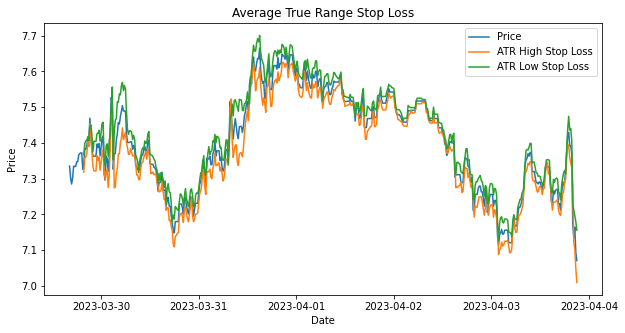

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define function to calculate ATR
def calculate_atr_stoploss(df, length=14):
    df['TR'] = np.max([df['High'] - df['Low'], abs(df['High'] - df['Close'].shift()), abs(df['Low'] - df['Close'].shift())], axis=0)
    df['ATR'] = df['TR'].rolling(window=length).mean()
    # Set inputs for stop loss calculation
    multiplier = 1.5
    src1 = 'High'
    src2 = 'Low'

    # Calculate stop loss levels
    df['ATR_High'] = df[src1] - multiplier * df['ATR']
    df['ATR_Low'] = df[src2] + multiplier * df['ATR']
    multiplier = 1.5
    src1 = 'High'
    src2 = 'Low'

    # Calculate stop loss levels
    df['ATR_High'] = df[src1] - multiplier * df['ATR']
    df['ATR_Low'] = df[src2] + multiplier * df['ATR']
    
    return df

# Load sample data
#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')
#print(df)
# Calculate ATR with default parameters
df = calculate_atr(df)

# Set inputs for stop loss calculation
multiplier = 1.5
src1 = 'High'
src2 = 'Low'

# Calculate stop loss levels
df['ATR_High'] = df[src1] - multiplier * df['ATR']
df['ATR_Low'] = df[src2] + multiplier * df['ATR']

# Plot stop loss levels
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df['Date'], df['Close'], label='Price')
ax.plot(df['Date'], df['ATR_High'], label='ATR High Stop Loss')
ax.plot(df['Date'], df['ATR_Low'], label='ATR Low Stop Loss')
ax.legend()
ax.set_title('Average True Range Stop Loss')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

# Print ATR and stop loss levels for last date
last_date = df


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def fibonacci_retracement(df, period=150):
    """
    Calculate Fibonacci retracement levels for a given DataFrame.
    
    Parameters:
    df (pd.DataFrame): OHLC data for a security.
    period (int): Lookback period to calculate highest high and lowest low.
    
    Returns:
    pd.DataFrame: DataFrame with Fibonacci retracement levels as columns.
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    hl = high.rolling(period).max() # Calculate highest high over lookback period
    ll = low.rolling(period).min() # Calculate lowest low over lookback period
    dist = hl - ll

    f0 = np.where(close[period] > close, hl, ll + dist)
    f1 = np.where(close[period] > close, hl - dist*0.236, ll + dist*0.786)
    f2 = np.where(close[period] > close, hl - dist*0.382, ll + dist*0.618)
    f3 = np.where(close[period] > close, hl - dist*0.5, ll + dist*0.5)
    f4 = np.where(close[period] > close, hl - dist*0.618, ll + dist*0.382)
    f5 = np.where(close[period] > close, hl - dist*0.786, ll + dist*0.236)
    f6 = np.where(close[period] > close, hl - dist, ll)

    # Create a DataFrame with the Fibonacci retracement levels as columns
    fib_levels = pd.DataFrame({
        '0.0': f0,
        '0.236': np.where(close[period] < close, f1, np.nan),
        '0.382': np.where(close[period] < close, f2, np.nan),
        '0.5': f3,
        '0.618': np.where(close[period] < close, f4, np.nan),
        '0.786': np.where(close[period] < close, f5, np.nan),
        '1.0': f6
    }, index=df.index)

    return fib_levels


In [156]:
import pandas as pd
import ta
import numpy as np

def volume_oscillator(df, shortlen=5, longlen=10, lookback=10):
    cumVol = 0
    cumVol += df['Volume'].fillna(0)
    if df['Volume'].isnull().all():
        raise ValueError("No volume is provided by the data vendor.")
    short = ta.volatility.bollinger_mavg(df['Volume'], window=shortlen)
    long = ta.volatility.bollinger_mavg(df['Volume'], window=longlen)
    osc = 100 * (short - long) / long
    df['VO'] = osc
    
    peaks_above_zero = np.zeros(len(osc))
    valleys_above_zero = np.zeros(len(osc))
    peaks_below_zero = np.zeros(len(osc))
    valleys_below_zero = np.zeros(len(osc))
    
    for i in range(lookback, len(osc)):
        window = osc[i-lookback:i+1]
        max_val = max(window)
        min_val = min(window)
        if max_val == osc[i] and max_val > 0:
            peaks_above_zero[i] = max_val
        elif max_val == osc[i] and max_val < 0:
            peaks_below_zero[i] = max_val
        if min_val == osc[i] and min_val > 0:
            valleys_above_zero[i] = min_val
        elif min_val == osc[i] and min_val < 0:
            valleys_below_zero[i] = min_val
    
    df['peaks_above_zero'] = peaks_above_zero
    df['valleys_above_zero'] = valleys_above_zero
    df['peaks_below_zero'] = peaks_below_zero
    df['valleys_below_zero'] = valleys_below_zero
    
    avg_peak_above_zero = np.mean(peaks_above_zero[np.nonzero(peaks_above_zero)])
    avg_valley_above_zero = np.mean(valleys_above_zero[np.nonzero(valleys_above_zero)])
    avg_peak_below_zero = np.mean(peaks_below_zero[np.nonzero(peaks_below_zero)])
    avg_valley_below_zero = np.mean(valleys_below_zero[np.nonzero(valleys_below_zero)])
    
    df['avg_peak_above_zero'] = avg_peak_above_zero
    df['avg_valley_below_zero'] = avg_valley_below_zero
    
    return df


In [147]:
import pandas as pd
import ta
import numpy as np
import scipy
def volume_oscillator(df, shortlen=5, longlen=10):
    cumVol = 0
    cumVol += df['Volume'].fillna(0)
    if df['Volume'].isnull().all():
        raise ValueError("No volume is provided by the data vendor.")
    short = ta.volatility.bollinger_mavg(df['Volume'], window=shortlen)
    long = ta.volatility.bollinger_mavg(df['Volume'], window=longlen)
    osc = 100 * (short - long) / long
    df['VO'] = osc
    
    # Calculate peaks above and below 0
    peaks, _ = scipy.signal.find_peaks(df['VO'], height=0)
    print(peaks)
    avg_above_0 = np.mean(df['VO'][peaks])
    avg_below_0 = np.mean(df['VO'][np.where(df['VO'] < 0)[0]])
    
    # Add new columns to highlight average peaks above and below 0
    df['avg_peak_above_0'] = np.where(df['VO'] > avg_above_0, df['VO'], np.nan)
    df['avg_peak_below_0'] = np.where(df['VO'] < avg_below_0, df['VO'], np.nan)
    
    return df


In [12]:
import pandas as pd
df = getData('LINK/USD','15m')

#df = volume_oscillator(df)



In [158]:
df.to_csv('data.csv')

In [232]:
import pandas as pd
import numpy as np
import ta

def calculate_vzo(df, length=14):
    close_prices = df['Close']
    volumes = df['Volume']
    volume_direction = close_prices.diff()
    volume_direction[volume_direction >= 0] = volumes[volume_direction >= 0]
    volume_direction[volume_direction < 0] = -volumes[volume_direction < 0]
    vzo_volume = pd.Series(volume_direction).ewm(span=length, min_periods=length).mean()
    total_volume = pd.Series(volumes).ewm(span=length, min_periods=length).mean()
    vzo = 100 * vzo_volume / total_volume
    df['VZO'] = vzo
    return df


In [30]:

df = getData('LINK/USDT','15m')
#df = calculate_vzo(df)
print(df)

                         Date   Open   High    Low  Close  Volume
0   2023-03-30 06:00:00-05:00  7.397  7.402  7.373  7.373   18.45
1   2023-03-30 06:15:00-05:00  7.377  7.378  7.377  7.378  101.43
2   2023-03-30 06:30:00-05:00  7.400  7.407  7.399  7.407   14.29
3   2023-03-30 06:45:00-05:00  7.407  7.407  7.407  7.407    0.00
4   2023-03-30 07:00:00-05:00  7.378  7.378  7.343  7.343   23.42
..                        ...    ...    ...    ...    ...     ...
495 2023-04-04 09:45:00-05:00  7.397  7.397  7.397  7.397    0.00
496 2023-04-04 10:00:00-05:00  7.397  7.397  7.397  7.397    0.00
497 2023-04-04 10:15:00-05:00  7.343  7.343  7.323  7.325   76.00
498 2023-04-04 10:30:00-05:00  7.351  7.351  7.325  7.325   21.37
499 2023-04-04 10:45:00-05:00  7.356  7.372  7.356  7.367   51.41

[500 rows x 6 columns]


In [236]:
df

,Date,Open,High,Low,Close,Volume,VZO
0,2023-03-29 18:00:00-05:00,7.385,7.405,7.385,7.397,128.45,NaN
1,2023-03-29 18:15:00-05:00,7.391,7.391,7.387,7.387,81.00,NaN
2,2023-03-29 18:30:00-05:00,7.398,7.398,7.398,7.398,3.37,NaN
3,2023-03-29 18:45:00-05:00,7.364,7.364,7.364,7.364,6.71,NaN
4,2023-03-29 19:00:00-05:00,7.386,7.386,7.386,7.386,8.12,NaN
...,...,...,...,...,...,...,...
495,2023-04-03 21:45:00-05:00,7.300,7.300,7.273,7.273,13.25,0.234375
496,2023-04-03 22:00:00-05:00,7.273,7.273,7.273,7.273,0.00,0.234375
497,2023-04-03 22:15:00-05:00,7.273,7.273,7.273,7.273,0.00,0.234375
498,2023-04-03 22:30:00-05:00,7.297,7.297,7.297,7.297,2.00,0.753163


In [256]:
df.to_csv('data.csv')

In [4]:
import ccxt

exchange = ccxt.gemini()
markets = exchange.load_markets()

tickers = list(markets.keys())

print(tickers)


['BTC/USD', 'BTC/EUR', 'BTC/GBP', 'BTC/SGD', 'ETH/BTC', 'ETH/USD', 'ETH/EUR', 'ETH/GBP', 'ETH/SGD', 'ZEC/USD', 'ZEC/BTC', 'ZEC/ETH', 'ZEC/BCH', 'ZEC/LTC', 'BCH/USD', 'BCH/BTC', 'BCH/ETH', 'LTC/USD', 'LTC/BTC', 'LTC/ETH', 'LTC/BCH', 'BAT/USD', 'DAI/USD', 'LINK/USD', 'OXT/USD', 'BAT/BTC', 'LINK/BTC', 'OXT/BTC', 'BAT/ETH', 'LINK/ETH', 'OXT/ETH', 'AMP/USD', 'COMP/USD', 'PAXG/USD', 'MKR/USD', 'ZRX/USD', 'KNC/USD', 'MANA/USD', 'STORJ/USD', 'SNX/USD', 'CRV/USD', 'BAL/USD', 'UNI/USD', 'REN/USD', 'UMA/USD', 'YFI/USD', 'BTC/DAI', 'ETH/DAI', 'AAVE/USD', 'FIL/USD', 'SKL/USD', 'GRT/USD', 'BNT/USD', '1INCH/USD', 'ENJ/USD', 'LRC/USD', 'SAND/USD', 'CUBE/USD', 'LPT/USD', 'BOND/USD', 'MATIC/USD', 'INJ/USD', 'SUSHI/USD', 'DOGE/USD', 'ALCX/USD', 'MIR/USD', 'FTM/USD', 'ANKR/USD', 'BTC/GUSD', 'ETH/GUSD', 'CTX/USD', 'XTZ/USD', 'AXS/USD', 'SLP/USD', 'LUNA/USD', 'UST/USD', 'MCO2/USD', 'DOGE/BTC', 'DOGE/ETH', 'WCFG/USD', 'RARE/USD', 'RAD/USD', 'QNT/USD', 'NMR/USD', 'MASK/USD', 'FET/USD', 'ASH/USD', 'AUDIO/USD',

In [5]:
def linear_regression_channel(source, length=100, use_upper_dev=True, upper_mult=2.0, use_lower_dev=True, lower_mult=2.0,
                              show_pearson=True, extend_left=False, extend_right=True, color_upper=(0, 0, 255, 85), color_lower=(255, 0, 0, 85)):
    def calc_slope(source, length):
        if length <= 1:
            return (np.nan, np.nan, np.nan)
        sum_x = sum_y = sum_x_sqr = sum_xy = 0.0
        for i in range(length):
            val = source[i]
            per = i + 1.0
            sum_x += per
            sum_y += val
            sum_x_sqr += per * per
            sum_xy += val * per
        slope = (length * sum_xy - sum_x * sum_y) / (length * sum_x_sqr - sum_x * sum_x)
        average = sum_y / length
        intercept = average - slope * sum_x / length + slope
        return (slope, average, intercept)

    def calc_dev(source, length, slope, average, intercept):
        up_dev = dn_dev = std_dev_acc = dsxx = dsyy = dsxy = 0.0
        periods = length - 1
        da_y = intercept + slope * periods / 2
        val = intercept
        for j in range(periods + 1):
            price = high[j] - val
            if price > up_dev:
                up_dev = price
            price = val - low[j]
            if price > dn_dev:
                dn_dev = price
            price = source[j]
            dxt = price - average
            dyt = val - da_y
            price -= val
            std_dev_acc += price * price
            dsxx += dxt * dxt
            dsyy += dyt * dyt
            dsxy += dxt * dyt
            val += slope
        std_dev = math.sqrt(std_dev_acc / (periods if periods > 0 else 1))
        pearson_r = dsxy / math.sqrt(dsxx * dsyy) if dsxx != 0 and dsyy != 0 else 0.0
        return (std_dev, pearson_r, up_dev, dn_dev)

    length_input = length
    source_input = source
    s, a, i = calc_slope(source_input, length_input)
    start_price = i + s * (length_input - 1)
    end_price = i

    base_line = None
    if np.isnan(start_price):
        return

    x = np.arange(len(source_input))
    y = [i + s * (j - length_input + 1) for j in range(length_input)]
    
    if base_line is None:
        base_line = pd.DataFrame(data={'x': x, 'y': y}, index=x)
    else:
        base_line['y'] = y
    base_line = base_line[x[0]:x[-1]+1]
    
    dev_data = calc_dev(source_input, length_input, s, a, i)
    std_dev = dev_data[0]
    pearson_r = dev_data[1]
    up_dev = dev_data[2]
    dn_dev = dev_data[3]
    print(base_line,dev_data,std_dev,pearson_r,up_dev,dn_dev)

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy import stats
def bollinger_bands(df, std_dev, lookback):
    # Compute rolling mean and standard deviation
    rolling_mean = df['Close'].rolling(window=lookback).mean()
    rolling_std = df['Close'].rolling(window=lookback).std()

    # Compute upper and lower bands
    upper_band = rolling_mean + (rolling_std * std_dev)
    lower_band = rolling_mean - (rolling_std * std_dev)

    # Compute linear regression
    x = np.arange(len(df))
    y = df['Close']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Compute Pearson correlation coefficient
    corr, _ = pearsonr(x, y)

    # Add columns to dataframe
    df['slope'] = slope
    df['intercept'] = intercept
    df['upper_dev'] = upper_band
    df['lower_dev'] = lower_band
    df['person_corr'] = corr

    return df


In [18]:
# import numpy as np
# linear_regression_channel(df['Close'])

In [53]:
df = getData('LINK/USDT','15m')
#bollinger_bands(df,2,100)

In [35]:
import numpy as np

import matplotlib.pyplot as plt

def calc_slope(source, length):
    """
    Calculates the slope, intercept and average for a given source and length using linear regression
    """
    x = np.arange(length)
    y = source[-length:]
    slope, intercept = np.polyfit(x, y, deg=1)
    average = np.mean(y)
    return slope, average, intercept

def calc_dev(source, length, slope, average, intercept):
    """
    Calculates the standard deviation, upper deviation and lower deviation for a given source and length
    """
    deviations = source[-length:] - (intercept + slope*np.arange(length)/length)
    std_dev = np.std(deviations)
    up_dev = np.max(deviations)
    dn_dev = np.min(deviations)
    return std_dev, up_dev, dn_dev

def plot_linear_regression_channel(source, length, upper_mult=2.0, lower_mult=2.0):
    """
    Plots the linear regression channel for a given source and length
    """
    slope, average, intercept = calc_slope(source, length)
    std_dev, up_dev, dn_dev = calc_dev(source, length, slope, average, intercept)
    upper_start_price = intercept + slope*(length-1) + upper_mult*std_dev
    upper_end_price = intercept + slope*0 + upper_mult*std_dev
    lower_start_price = intercept + slope*(length-1) - lower_mult*std_dev
    lower_end_price = intercept + slope*0 - lower_mult*std_dev
    
    plt.plot(source[-length:], label='Source')
    plt.plot(np.arange(length), intercept + slope*np.arange(length)/length, label='LinReg')
    plt.plot(np.arange(length), upper_start_price + (upper_end_price-upper_start_price)*np.arange(length)/length, label='Upper Channel')
    plt.plot(np.arange(length), lower_start_price + (lower_end_price-lower_start_price)*np.arange(length)/length, label='Lower Channel')
    plt.legend()
    plt.show()


In [58]:
import numpy as np
import pandas as pd

def calc_slope(source_column, length):
    """
    Calculates the slope, intercept and average for a given source column and length using linear regression
    """
    x = np.arange(length)
    y = source_column[-length:]
    slope, intercept = np.polyfit(x, y, deg=1)
    average = np.mean(y)
    return slope, average, intercept

def calc_dev(source_column, length, slope, average, intercept):
    """
    Calculates the standard deviation, upper deviation and lower deviation for a given source column and length
    """
    deviations = source_column[-length:] - (intercept + slope*np.arange(length)/length)
    std_dev = np.std(deviations)
    up_dev = np.max(deviations)
    dn_dev = np.min(deviations)
    return std_dev, up_dev, dn_dev

def calc_linear_regression_channel(df, length, upper_mult=2.0, lower_mult=2.0):
    """
    Calculates the linear regression channel for a given dataframe and length.
    Adds the upper and lower channel values as new columns to the dataframe.
    """
    source_column = df['Close']
    slope, average, intercept = calc_slope(source_column, length)
    std_dev, up_dev, dn_dev = calc_dev(source_column, length, slope, average, intercept)
    upper_start_price = intercept + slope*(length-1) + upper_mult*std_dev*np.sqrt(length)
    upper_end_price = intercept + slope*0 + upper_mult*std_dev*np.sqrt(length)
    lower_start_price = intercept + slope*(length-1) - lower_mult*std_dev*np.sqrt(length)
    lower_end_price = intercept + slope*0 - lower_mult*std_dev*np.sqrt(length)
    
    # Add new columns to dataframe
    df['LinReg'] = np.nan
    df['Upper Channel'] = np.nan
    df['Lower Channel'] = np.nan
    
    df['LinReg'].iloc[-length:] = intercept + slope*np.arange(length)/length
    df['Upper Channel'].iloc[-length:] = upper_start_price + (upper_end_price-upper_start_price)*np.arange(length)/length
    df['Lower Channel'].iloc[-length:] = lower_start_price + (lower_end_price-lower_start_price)*np.arange(length)/length
    
   


    return df

[*********************100%***********************]  1 of 1 completed


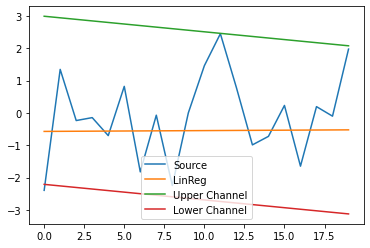

In [41]:
import yfinance as yf

# Download historical data for Apple
apple = yf.download('AAPL', start='2020-01-01')
# Generate some random data
data = np.random.normal(size=100)

# Plot the linear regression channel
plot_linear_regression_channel(data, length=20)


In [59]:
calc_linear_regression_channel(df, 100, upper_mult=2.0, lower_mult=2.0)

C:\Users\jdlugosz\AppData\Local\Temp\ipykernel_23532\1814534248.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LinReg'].iloc[-length:] = intercept + slope*np.arange(length)/length
C:\Users\jdlugosz\AppData\Local\Temp\ipykernel_23532\1814534248.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Upper Channel'].iloc[-length:] = upper_start_price + (upper_end_price-upper_start_price)*np.arange(length)/length
C:\Users\jdlugosz\AppData\Local\Temp\ipykernel_23532\1814534248.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,Date,Open,High,Low,Close,Volume,LinReg,Upper Channel,Lower Channel
0,2023-03-30 06:30:00-05:00,7.400,7.407,7.399,7.407,14.29,NaN,NaN,NaN
1,2023-03-30 06:45:00-05:00,7.407,7.407,7.407,7.407,0.00,NaN,NaN,NaN
2,2023-03-30 07:00:00-05:00,7.378,7.378,7.343,7.343,23.42,NaN,NaN,NaN
3,2023-03-30 07:15:00-05:00,7.340,7.340,7.340,7.340,0.48,NaN,NaN,NaN
4,2023-03-30 07:30:00-05:00,7.340,7.340,7.340,7.340,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
495,2023-04-04 10:15:00-05:00,7.343,7.343,7.323,7.325,76.00,7.220339,8.748437,5.703263
496,2023-04-04 10:30:00-05:00,7.351,7.351,7.325,7.325,21.37,7.220353,8.747073,5.701899
497,2023-04-04 10:45:00-05:00,7.356,7.372,7.356,7.367,51.41,7.220366,8.745709,5.700535
498,2023-04-04 11:00:00-05:00,7.367,7.367,7.367,7.367,0.00,7.220380,8.744345,5.699171


In [62]:
# This source code is subject to the terms of the Mozilla Public License 2.0 at https://mozilla.org/MPL/2.0/
# © LonesomeTheBlue

from talib import LINEARREG
import numpy as np
import matplotlib.pyplot as plt

src = close # input(defval=close, title="Source")
length = 100 # input(defval=100, title="Length", minval=10)
deviation_length = 2.0 # input(defval=2., title="Deviation", minval=0.1, step=0.1)
extend_lines = True # input(defval=True, title="Extend Lines")
show_fibonacci_levels = False # input(defval=False, title="Show Fibonacci Levels")
show_broken_channel = True # input(defval=True, title="Show Broken Channel", inline="brk")
broken_channel_color = 'blue' # input(defval=color.blue, title="", inline="brk")
up_trend_color = 'lime' # input(defval=color.lime, title="Up/Down Trend Colors", inline="trcols")
down_trend_color = 'red' # input(defval=color.red, title="", inline="trcols")
line_width = 2 # input(defval=2, title="Line Width")

fibo_ratios = [0.236, 0.382, 0.618, 0.786]
colors = [up_trend_color, down_trend_color]

def get_channel(src, length):
    mid = np.sum(src[-length:]) / length
    slope = LINEARREG(src, timeperiod=length)[-1] - LINEARREG(src, timeperiod=length)[-2]
    intercept = mid - slope * np.floor(length / 2) + ((1 - (length % 2)) / 2) * slope
    end_y = intercept + slope * (length - 1)
    dev = np.sqrt(np.sum((src[-length:] - (slope * (length - np.arange(length)) + intercept))**2) / length)
    return intercept, end_y, dev, slope

y1, y2, deviation, slope = get_channel(src, length)

out_of_channel = -1
if slope > 0 and close[-1] < y2 - deviation * deviation_length:
    out_of_channel = 0
elif slope < 0 and close[-1] > y2 + deviation * deviation_length:
    out_of_channel = 2

reg_lines = [None] * 3
fibo_lines = [None] * 4
for x in range(3):
    if show_broken_channel and out_of_channel == x and (len(out_of_channel) < 2 or out_of_channel[-2] == -1):
        continue
    else:
        reg_lines[x].remove()
    reg_lines[x] = plt.plot(np.arange(length)-length+1, [y1+deviation*deviation_length*(x-1), y2+deviation*deviation_length*(x-1)] , color=colors[int(np.sign(slope)>0)], 
                 linestyle='solid' if x % 2 == 0 else 'dashed', linewidth=line_width, zorder=1)
    if extend_lines:
        plt.plot([np.arange(length)[-1]-length+1, np.arange(length)[-1]-length+1], [y1+deviation*deviation_length*(x-1), y2+deviation*deviation_length*(x-1)], 
                 color=colors[int(np.sign(slope)>0)], linestyle ='dashed', linewidth=line_width, zorder=1)

if show_fibonacci_levels:
    for i, ratio in enumerate(fibo_ratios):
        fibo_lines[i], = plt.plot(np.arange(length)-length+1, [y2+deviationdeviation_lengthratio*(x-1) for x in range(3)],
        color='grey', linestyle='dotted', linewidth=1, zorder=0)

if show_broken_channel and out_of_channel != -1 and (len(out_of_channel) < 2 or out_of_channel[-2] == -1):
    plt.plot(np.arange(length)-length+1, [y1+deviationdeviation_length(out_of_channel-1), y2+deviationdeviation_length(out_of_channel-1)],
    color=broken_channel_color, linestyle='dashed', linewidth=line_width, zorder=1)

plt.title("Regression Channel")
plt.xlabel("Bars Ago")
plt.ylabel("Price")
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'talib'

In [3]:
import talib
import numpy as np
import pandas as pd

def get_channel(src, length, deviation_length):
    mid = talib.SMA(src, length)
    slope, intercept = talib.LINEARREG_SLOPE(src, length), mid - talib.LINEARREG(src, length)
    end_y = intercept + slope * (length - 1)
    dev = np.sqrt(((src - (slope * np.arange(length) + intercept)) ** 2).mean())
    return mid, end_y, dev, slope

def linear_regression_channel(src, length=100, deviation_length=2.0):
    mid, end_y, dev, slope = get_channel(src, length, deviation_length)
    out_of_channel = np.where((slope > 0) & (src < end_y - dev * deviation_length), 0,
                              np.where((slope < 0) & (src > end_y + dev * deviation_length), 2, -1))
    
    df = pd.DataFrame({
        'mid': mid[-length:],
        'end_y': end_y[-length:],
        'dev': dev[-length:],
        'slope': slope[-length:],
        'out_of_channel': out_of_channel[-length:]
    })
    
    return df


In [113]:
def get_channel(src, length, deviation_length):
    mid = talib.SMA(src, length)
    slope, intercept = np.polyfit(np.arange(length), src[-length:], 1)
    endy = intercept + slope * (length - 1)
    deviations = np.sqrt(np.sum(np.power(src[-length:] - (slope * np.arange(length) + intercept), 2)) / length)
    upper = endy + deviations * deviation_length
    lower = endy - deviations * deviation_length
    return upper, mid, lower, slope

In [2]:
import pandas as pd
import numpy as np
import math

# define the get_channel function
def get_channel(src, length):
   
    def linreg(src, length, offset):
        x = np.arange(length) + offset
        y = src[offset:length+offset]
        slope, intercept = np.polyfit(x, y, 1)
        return slope

    mid = sum(src[:length]) / length
    slope = linreg(src, length, 0) - linreg(src, length, 1)
    intercept  = mid - slope * math.floor(length / 2) + ((1 - (length % 2)) / 2) * slope
    endy = intercept  + slope * (length - 1) 
    dev = 0.0
    for x in range(length):
        dev += pow(src[x] - (slope * (length - x) + intercept), 2)
    dev = math.sqrt(dev/length)
    return pd.DataFrame({'intercept': [intercept], 'endy': [endy], 'dev': [dev], 'slope': [slope]})

# create an example dataframe
df = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [6, 7, 8, 9, 10],
    'C': [11, 12, 13, 14, 15],
    'D': [16, 17, 18, 19, 20],
    'E': [21, 22, 23, 24, 25]
})

# apply the get_channel function to the entire dataframe
result = df.rolling(window=3).apply(lambda x: get_channel(x, len(x)))
print(result)


DataError: No numeric types to aggregate

In [114]:
df = getData('LINK/USDT','15m')
upper, mid, lower, slope =get_channel(df['Close'],100,2)

In [115]:
get_channel(df['Close'], 100).values[0]


TypeError: get_channel() missing 1 required positional argument: 'deviation_length'

In [97]:
upper

7.510188788003616

In [98]:
mid

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
495    7.29268
496    7.29444
497    7.29632
498    7.29791
499    7.29908
Length: 500, dtype: float64

In [99]:
lower

7.252687251600344

In [100]:
slope

0.0016637983798379861

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

def linear_regression_channel(df, lookback, std_deviation):
    if 'Close' not in df:
        raise KeyError('Close column not found in input DataFrame')
    if len(df) < lookback:
        raise ValueError('Input DataFrame is too small for the specified lookback period')
    
    # Compute the linear regression line for each window of size 'lookback'
    x = np.arange(lookback).reshape(-1, 1)
    linreg = LinearRegression()
    linreg.fit(x, df['Close'][-lookback:])
    slope = linreg.coef_[0]
    intercept = linreg.intercept_
    linreg_line = intercept + slope * x.flatten()
    # Compute the Pearson correlations between the closing prices and the linear regression line
    #corr, _ = pearsonr(df['Close'], linreg_line)
    # Compute the upper and lower channels using 'std_deviation' standard deviations
    #std = np.std(df['Close'][-lookback:])
    std = np.std(df['Close'][-lookback:]-linreg_line)
    upper_channel = linreg_line + std_deviation * std
    lower_channel = linreg_line - std_deviation * std
    
  
    # Add the upper, middle, and lower channels to the original dataframe as new columns
    df['Upper_Channel'] = upper_channel
    df['Middle_Channel'] = linreg_line
    df['Lower_Channel'] = lower_channel
    #df['Correlation'] = corr
    
    
    return df



In [24]:
def getData(symbol,time):
    """
    1504541580000, // UTC timestamp in milliseconds, integer
    4235.4,        // (O)pen price, float
    4240.6,        // (H)ighest price, float
    4230.0,        // (L)owest price, float
    4230.7,        // (C)losing price, float
    37.72941911    // (V)olume float (usually in terms of the base currency, the exchanges docstring may list whether quote or base units are used)
    """
    
    # Initialize the Binance exchange object
    binance = ccxt.binance()
    # Fetch historical OHLCV data
    ohlcv = binance.fetch_ohlcv(symbol, time)
    
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df = pd.DataFrame(ohlcv, columns=columns)

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('America/Chicago')

    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    return df

In [63]:
def linear_regression_channel(df, lookback, std_deviation):
    if 'Close' not in df:
        raise KeyError('Close column not found in input DataFrame')
    if len(df) < lookback:
        raise ValueError('Input DataFrame is too small for the specified lookback period')
    
    # Create an empty DataFrame to store the channel data
    channel_df = pd.DataFrame()
    
    # Loop through the DataFrame and compute the channels for each window
    for i in range(len(df)):
        if i >= lookback:
            # Subset the DataFrame to the current window of size 'lookback'
            window_df = df.iloc[i-lookback:i]
            
            # Compute the linear regression line for the current window
            x = np.arange(lookback).reshape(-1, 1)
            linreg = LinearRegression()
            linreg.fit(x, window_df['Close'])
            slope = linreg.coef_[0]
            intercept = linreg.intercept_
            linreg_line = intercept + slope * x.flatten()
            
            # Compute the upper and lower channels for the current window
            std = np.std(window_df['Close']-linreg_line)
            upper_channel = linreg_line + std_deviation * std
            lower_channel = linreg_line - std_deviation * std
            
            # Add the upper, middle, and lower channels to the channel DataFrame
            channel_df = pd.concat([channel_df, pd.DataFrame({'Upper_Channel': upper_channel, 
                                                               'Middle_Channel': linreg_line, 
                                                               'Lower_Channel': lower_channel}, 
                                                              index=window_df.index)], axis=0)
            #df = df.reset_index(drop=True)
    
    # Add the channel columns to the original DataFrame
    # print(df)
    print(channel_df)
    #df = pd.concat([df, channel_df], axis=1)
    print(channel_df)
    
    return channel_df


In [64]:
import ccxt
df = getData('LINK/USDT','15m')


lookback = 100
std_deviation = 2

# Apply the function to each rolling window of data and concatenate the resulting dataframes
result = linear_regression_channel(df,lookback,std_deviation)
#linear_regression_channel(df,100,2)
# Save the results to a new CSV file
result.to_csv('linear_regression_channel_results.csv', index=False)

     Upper_Channel  Middle_Channel  Lower_Channel
0         7.288871        7.208885       7.128899
1         7.293556        7.213570       7.133585
2         7.298241        7.218255       7.138270
3         7.302926        7.222941       7.142955
4         7.307611        7.227626       7.147640
..             ...             ...            ...
494       7.504237        7.438575       7.372913
495       7.506315        7.440653       7.374991
496       7.508392        7.442731       7.377069
497       7.510470        7.444808       7.379147
498       7.512548        7.446886       7.381224

[40000 rows x 3 columns]
     Upper_Channel  Middle_Channel  Lower_Channel
0         7.288871        7.208885       7.128899
1         7.293556        7.213570       7.133585
2         7.298241        7.218255       7.138270
3         7.302926        7.222941       7.142955
4         7.307611        7.227626       7.147640
..             ...             ...            ...
494       7.504237      

In [66]:
import pandas as pd

# create a DataFrame with 500 rows
df = pd.DataFrame({'A': range(500), 'B': range(500, 1000)})

# loop through the DataFrame in increments of 100 rows
for i in range(0, 500, 100):
    # select the rows from i to i+99 using iloc
    subset_df = df.iloc[i:i+100]
    # do something with the subset DataFrame, e.g.
    print(subset_df)


     A    B
0    0  500
1    1  501
2    2  502
3    3  503
4    4  504
..  ..  ...
95  95  595
96  96  596
97  97  597
98  98  598
99  99  599

[100 rows x 2 columns]
       A    B
100  100  600
101  101  601
102  102  602
103  103  603
104  104  604
..   ...  ...
195  195  695
196  196  696
197  197  697
198  198  698
199  199  699

[100 rows x 2 columns]
       A    B
200  200  700
201  201  701
202  202  702
203  203  703
204  204  704
..   ...  ...
295  295  795
296  296  796
297  297  797
298  298  798
299  299  799

[100 rows x 2 columns]
       A    B
300  300  800
301  301  801
302  302  802
303  303  803
304  304  804
..   ...  ...
395  395  895
396  396  896
397  397  897
398  398  898
399  399  899

[100 rows x 2 columns]
       A    B
400  400  900
401  401  901
402  402  902
403  403  903
404  404  904
..   ...  ...
495  495  995
496  496  996
497  497  997
498  498  998
499  499  999

[100 rows x 2 columns]


In [40]:
# create a sample DataFrame with 500 rows
df = pd.DataFrame({'Close': np.random.rand(500)})
print(df['Close'].head())
# specify the lookback period and standard deviation
lookback = 100
std_deviation = 1.5

# apply the function to each rolling window of size 'lookback'
results = df['Close'].rolling(window=lookback).apply(linear_regression_channel, args=(lookback, std_deviation))

# drop rows with NaN values (outside of the most recent 'lookback' rows)
results.dropna(inplace=True)

# print the results
print(results)


0    0.261821
1    0.384584
2    0.796348
3    0.273640
4    0.713794
Name: Close, dtype: float64


KeyError: 'Close column not found in input DataFrame'

In [32]:
import numpy as np
import pandas as pd

# create a sample DataFrame with 500 rows
df = pd.DataFrame({'Close': np.random.rand(500)})

# specify the lookback period and standard deviation
lookback = 100
std_deviation = 1.5

# create a rolling window of the DataFrame and apply the function to each window
results = df['Close'].rolling(window=lookback).apply(lambda x: linear_regression_channel(pd.DataFrame(x), lookback=lookback, std_deviation=std_deviation))

# print the results
print(results)


KeyError: 'Close column not found in input DataFrame'

In [51]:
df

,Date,Open,High,Low,Close,Volume
0,2023-03-28 04:00:00-05:00,6.85349,6.85349,6.85349,6.85349,0.000000
1,2023-03-28 04:15:00-05:00,6.80628,6.80628,6.80628,6.80628,12.010122
2,2023-03-28 04:30:00-05:00,6.79604,6.79717,6.79604,6.79717,32.028218
3,2023-03-28 04:45:00-05:00,6.78581,6.78581,6.77485,6.77485,31.160005
4,2023-03-28 05:00:00-05:00,6.76119,6.76119,6.75769,6.75769,13.055284
...,...,...,...,...,...,...
715,2023-04-04 14:45:00-05:00,7.39346,7.39346,7.39346,7.39346,0.000000
716,2023-04-04 15:00:00-05:00,7.42379,7.42561,7.42379,7.42561,31.477815
717,2023-04-04 15:15:00-05:00,7.43908,7.44795,7.43632,7.43823,582.986285
718,2023-04-04 15:30:00-05:00,7.42227,7.46373,7.42227,7.46373,139.198533


In [43]:
upper_channel

array([7.34656434, 7.34907102, 7.35157771, 7.35408439, 7.35659108,
       7.35909776, 7.36160445, 7.36411114, 7.36661782, 7.36912451,
       7.37163119, 7.37413788, 7.37664456, 7.37915125, 7.38165794,
       7.38416462, 7.38667131, 7.38917799, 7.39168468, 7.39419137,
       7.39669805, 7.39920474, 7.40171142, 7.40421811, 7.40672479,
       7.40923148, 7.41173817, 7.41424485, 7.41675154, 7.41925822,
       7.42176491, 7.42427159, 7.42677828, 7.42928497, 7.43179165,
       7.43429834, 7.43680502, 7.43931171, 7.44181839, 7.44432508,
       7.44683177, 7.44933845, 7.45184514, 7.45435182, 7.45685851,
       7.45936519, 7.46187188, 7.46437857, 7.46688525, 7.46939194,
       7.47189862, 7.47440531, 7.47691199, 7.47941868, 7.48192537,
       7.48443205, 7.48693874, 7.48944542, 7.49195211, 7.49445879,
       7.49696548, 7.49947217, 7.50197885, 7.50448554, 7.50699222,
       7.50949891, 7.5120056 , 7.51451228, 7.51701897, 7.51952565,
       7.52203234, 7.52453902, 7.52704571, 7.5295524 , 7.53205

In [44]:
linreg_line

array([7.17916646, 7.18167314, 7.18417983, 7.18668651, 7.1891932 ,
       7.19169988, 7.19420657, 7.19671326, 7.19921994, 7.20172663,
       7.20423331, 7.20674   , 7.20924668, 7.21175337, 7.21426006,
       7.21676674, 7.21927343, 7.22178011, 7.2242868 , 7.22679348,
       7.22930017, 7.23180686, 7.23431354, 7.23682023, 7.23932691,
       7.2418336 , 7.24434028, 7.24684697, 7.24935366, 7.25186034,
       7.25436703, 7.25687371, 7.2593804 , 7.26188709, 7.26439377,
       7.26690046, 7.26940714, 7.27191383, 7.27442051, 7.2769272 ,
       7.27943389, 7.28194057, 7.28444726, 7.28695394, 7.28946063,
       7.29196731, 7.294474  , 7.29698069, 7.29948737, 7.30199406,
       7.30450074, 7.30700743, 7.30951411, 7.3120208 , 7.31452749,
       7.31703417, 7.31954086, 7.32204754, 7.32455423, 7.32706091,
       7.3295676 , 7.33207429, 7.33458097, 7.33708766, 7.33959434,
       7.34210103, 7.34460771, 7.3471144 , 7.34962109, 7.35212777,
       7.35463446, 7.35714114, 7.35964783, 7.36215452, 7.36466

In [45]:
lower_channel

array([7.01176858, 7.01427526, 7.01678195, 7.01928863, 7.02179532,
       7.024302  , 7.02680869, 7.02931538, 7.03182206, 7.03432875,
       7.03683543, 7.03934212, 7.0418488 , 7.04435549, 7.04686218,
       7.04936886, 7.05187555, 7.05438223, 7.05688892, 7.0593956 ,
       7.06190229, 7.06440898, 7.06691566, 7.06942235, 7.07192903,
       7.07443572, 7.0769424 , 7.07944909, 7.08195578, 7.08446246,
       7.08696915, 7.08947583, 7.09198252, 7.0944892 , 7.09699589,
       7.09950258, 7.10200926, 7.10451595, 7.10702263, 7.10952932,
       7.11203601, 7.11454269, 7.11704938, 7.11955606, 7.12206275,
       7.12456943, 7.12707612, 7.12958281, 7.13208949, 7.13459618,
       7.13710286, 7.13960955, 7.14211623, 7.14462292, 7.14712961,
       7.14963629, 7.15214298, 7.15464966, 7.15715635, 7.15966303,
       7.16216972, 7.16467641, 7.16718309, 7.16968978, 7.17219646,
       7.17470315, 7.17720983, 7.17971652, 7.18222321, 7.18472989,
       7.18723658, 7.18974326, 7.19224995, 7.19475663, 7.19726

In [6]:
from binance.client import Client
import config
# Initialize the Binance client object
client =  Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)

# Get exchange information
exchange_info = client.get_exchange_info()

# Loop through symbols and print their names
for symbol in exchange_info['symbols']:
    print(symbol['symbol'])

BNBBUSD
BTCBUSD
ETHBUSD
LTCBUSD
TRXBUSD
XRPBUSD
BNBUSDT
BTCUSDT
ETHUSDT
LTCUSDT
TRXUSDT
XRPUSDT
BNBBTC
ETHBTC
LTCBTC
TRXBTC
XRPBTC
LTCBNB
TRXBNB
XRPBNB


In [7]:

# Get the current price of Chainlink
symbol_ticker = client.get_symbol_ticker(symbol='LTCUSDT')
link_price = symbol_ticker['price']

# Print the current price of Chainlink
print('Current price of Chainlink:', link_price)

Current price of Chainlink: 92.15000000


In [56]:
def getData(symbol,time):
    """
    1504541580000, // UTC timestamp in milliseconds, integer
    4235.4,        // (O)pen price, float
    4240.6,        // (H)ighest price, float
    4230.0,        // (L)owest price, float
    4230.7,        // (C)losing price, float
    37.72941911    // (V)olume float (usually in terms of the base currency, the exchanges docstring may list whether quote or base units are used)
    """
    
    # Initialize the Binance exchange object
    binance = ccxt.binanceus()
    # Fetch historical OHLCV data
    symbol = symbol.replace('USDT', '/USDT')
    ohlcv = binance.fetch_ohlcv(symbol, time)
    
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df = pd.DataFrame(ohlcv, columns=columns)

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('America/Chicago')

    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    return df

In [21]:
import pandas as pd
df = getData('LTCUSDT','15m')

In [23]:
import talib
atr = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [24]:
atr

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14      0.779286
15      0.750765
16      0.721425
17      0.682037
18      0.646892
19      7.296400
20      6.788800
21     17.411028
22     20.506669
23     21.087621
24     36.676363
25     49.556622
26     68.661149
27     69.856067
28     73.347777
29     68.935078
30     75.134001
31     80.893716
32     88.891307
33     89.657643
34     88.254954
35     81.994600
36     87.663557
37     81.428303
38     75.686996
39     93.047925
40     97.115930
41     90.206221
42     90.801491
43     87.890670
44     85.847765
45     87.952925
46    104.964858
47    106.159511
48     99.983832
dtype: float64

In [4]:
import ccxt
import config
# Create an instance of the Binance exchange class with API keys
exchange = ccxt.phemex({
    'apiKey': config.key,
    'secret': config.secret
})

# Fetch the ticker for the BTC/USDT symbol
ticker = exchange.fetch_ticker('LINK/USDT')

# Print the ticker
print(ticker)


{'symbol': 'LINK/USDT', 'timestamp': 1680709475345, 'datetime': '2023-04-05T15:44:35.345Z', 'high': 7.604, 'low': 7.2192, 'bid': 7.33, 'bidVolume': None, 'ask': 7.332, 'askVolume': None, 'vwap': 7.450269073849394, 'open': 7.352, 'close': 7.33, 'last': 7.33, 'previousClose': None, 'change': -0.022, 'percentage': -0.2992383025027203, 'average': 7.341, 'baseVolume': 52016.27, 'quoteVolume': 387535.207718, 'info': {'askEp': '733200000', 'bidEp': '733000000', 'highEp': '760400000', 'indexEp': '733250000', 'lastEp': '733000000', 'lowEp': '721920000', 'openEp': '735200000', 'symbol': 'sLINKUSDT', 'timestamp': '1680709475345570090', 'turnoverEv': '38753520771800', 'volumeEv': '5201627000000'}}


In [5]:
exchange.fetch_balance()

AuthenticationError: phemex {"msg":"Api key not found e8d5ba6b-24a0-4dfb-b25d-52d98fb086dc","code":10500}

In [40]:
from binance import Client, ThreadedWebsocketManager

client =  Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)



In [51]:
from binance.client import Client
from binance.websockets import BinanceSocketManager
from twisted.internet import reactor

ModuleNotFoundError: No module named 'binance.websockets'

In [50]:
client =  Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)

bm = BinanceSocketManager(client)

# Define the callback function for the OHLCV data
def process_message(msg):
    print(msg)

# Start the WebSocket connection for the OHLCV data
conn_key = bm.start_klines_socket(symbol, process_message, interval=interval)

# Start the event loop for the WebSocket connection
bm.start()

# Run the event loop for the WebSocket connection
reactor.run()

TypeError: Client.get_symbol_ticker() takes 1 positional argument but 2 were given

In [53]:
import websocket
import json
import time

def on_message(ws, message):
    data = json.loads(message)
    print(data)

# Set the symbol and interval
symbol = "btcusdt"
interval = "1m"

# Start the WebSocket connection for the OHLCV data
socket = f"wss://stream.binance.com:9443/ws/{symbol}@kline_{interval}"
ws = websocket.create_connection(socket)
ws.send('{"method": "SUBSCRIBE","params":["btcusdt@kline_1m"],"id": 1}')
while True:
    result = ws.recv()
    on_message(ws, result)

AttributeError: module 'websocket' has no attribute 'create_connection'

In [ ]:
client.get_symbol_ticker

In [57]:
def stochastic_oscillator(df, periodK=14, smoothK=1, periodD=3):
    k_values = []
    d_values = []
    close = df['Close']
    high = df['High']
    low = df['Low'] 
    for i in range(len(close)):
        if i < periodK:
            k_values.append(np.nan)
        else:
            period_high = high[i - periodK : i].max()
            period_low = low[i - periodK : i].min()
            k = (close[i] - period_low) / (period_high - period_low) * 100
            k_smoothed = np.mean(k_values[i - smoothK + 1 : i + 1])
            k_values.append((k + 2*k_smoothed)/3)
        
        if i < periodK + periodD - 1:
            d_values.append(np.nan)
        else:
            d = np.mean(k_values[i - periodD + 1 : i + 1])
            d_values.append(d)
        
    return k_values, d_values

In [87]:
import pandas as pd
import ccxt
import numpy as np
df = getData('DOGEUSDT','15m')

In [69]:
# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['High'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['Low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['Close'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()

In [89]:
df

,Date,Open,High,Low,Close,Volume
0,2023-04-01 05:15:00-05:00,0.07632,0.07655,0.07620,0.07655,112647.0
1,2023-04-01 05:30:00-05:00,0.07655,0.07655,0.07655,0.07655,0.0
2,2023-04-01 05:45:00-05:00,0.07651,0.07651,0.07647,0.07647,6800.0
3,2023-04-01 06:00:00-05:00,0.07636,0.07636,0.07623,0.07623,12803.0
4,2023-04-01 06:15:00-05:00,0.07625,0.07625,0.07624,0.07624,11272.0
...,...,...,...,...,...,...
495,2023-04-06 09:00:00-05:00,0.08875,0.08923,0.08867,0.08920,20817.0
496,2023-04-06 09:15:00-05:00,0.08924,0.08932,0.08895,0.08913,207582.0
497,2023-04-06 09:30:00-05:00,0.08921,0.08926,0.08895,0.08914,68315.0
498,2023-04-06 09:45:00-05:00,0.08921,0.08947,0.08920,0.08926,276546.0


In [94]:
import pandas_ta as ta
# Add some indicators
df[['K','D']]=df.ta.stoch(high='High', low='Low',close='Close', k=14, d=3)


In [95]:
df

,Date,Open,High,Low,Close,Volume,STOCHk_14_3_3,STOCHd_14_3_3,K,D
0,2023-04-01 05:15:00-05:00,0.07632,0.07655,0.07620,0.07655,112647.0,NaN,NaN,NaN,NaN
1,2023-04-01 05:30:00-05:00,0.07655,0.07655,0.07655,0.07655,0.0,NaN,NaN,NaN,NaN
2,2023-04-01 05:45:00-05:00,0.07651,0.07651,0.07647,0.07647,6800.0,NaN,NaN,NaN,NaN
3,2023-04-01 06:00:00-05:00,0.07636,0.07636,0.07623,0.07623,12803.0,NaN,NaN,NaN,NaN
4,2023-04-01 06:15:00-05:00,0.07625,0.07625,0.07624,0.07624,11272.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
495,2023-04-06 09:00:00-05:00,0.08875,0.08923,0.08867,0.08920,20817.0,44.265394,44.494059,44.265394,44.494059
496,2023-04-06 09:15:00-05:00,0.08924,0.08932,0.08895,0.08913,207582.0,50.163766,46.239730,50.163766,46.239730
497,2023-04-06 09:30:00-05:00,0.08921,0.08926,0.08895,0.08914,68315.0,54.487179,49.638780,54.487179,49.638780
498,2023-04-06 09:45:00-05:00,0.08921,0.08947,0.08920,0.08926,276546.0,55.256410,53.302452,55.256410,53.302452


In [93]:
df.dropna()

,Date,Open,High,Low,Close,Volume,STOCHk_14_3_3,STOCHd_14_3_3
17,2023-04-01 09:30:00-05:00,0.07625,0.07628,0.07606,0.07611,27902.0,36.448598,46.002077
18,2023-04-01 09:45:00-05:00,0.07629,0.07629,0.07609,0.07609,48186.0,27.102804,37.383178
19,2023-04-01 10:00:00-05:00,0.07607,0.07629,0.07606,0.07629,15827.0,25.545171,29.698858
20,2023-04-01 10:15:00-05:00,0.07651,0.07651,0.07647,0.07651,18604.0,38.006231,30.218069
21,2023-04-01 10:30:00-05:00,0.07652,0.07652,0.07639,0.07648,17621.0,47.331256,36.960886
...,...,...,...,...,...,...,...,...
495,2023-04-06 09:00:00-05:00,0.08875,0.08923,0.08867,0.08920,20817.0,44.265394,44.494059
496,2023-04-06 09:15:00-05:00,0.08924,0.08932,0.08895,0.08913,207582.0,50.163766,46.239730
497,2023-04-06 09:30:00-05:00,0.08921,0.08926,0.08895,0.08914,68315.0,54.487179,49.638780
498,2023-04-06 09:45:00-05:00,0.08921,0.08947,0.08920,0.08926,276546.0,55.256410,53.302452


In [97]:
from binance import Client
client =  Client(api_key=config.key,api_secret=config.secret,tld='us',testnet=True)

In [102]:
client.get_account()

{'makerCommission': 0,
 'takerCommission': 0,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'commissionRates': {'maker': '0.00000000',
  'taker': '0.00000000',
  'buyer': '0.00000000',
  'seller': '0.00000000'},
 'canTrade': True,
 'canWithdraw': False,
 'canDeposit': False,
 'brokered': False,
 'requireSelfTradePrevention': False,
 'updateTime': 1680810093193,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1000.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '0.99900000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '10028.00629144', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'permissions': ['SPOT']}

In [103]:
symbol = 'BTCUSDT'

# get all orders for the specified symbol
orders = client.get_all_orders(symbol=symbol)

In [104]:
orders

[{'symbol': 'BTCUSDT',
  'orderId': 841668,
  'orderListId': -1,
  'clientOrderId': 'TORcfeLUYDeU1t3Yi4Q6oa',
  'price': '0.00000000',
  'origQty': '0.00100000',
  'executedQty': '0.00100000',
  'cummulativeQuoteQty': '28.00629144',
  'status': 'FILLED',
  'timeInForce': 'GTC',
  'type': 'MARKET',
  'side': 'SELL',
  'stopPrice': '0.00000000',
  'icebergQty': '0.00000000',
  'time': 1680810093193,
  'updateTime': 1680810093193,
  'isWorking': True,
  'workingTime': 1680810093193,
  'origQuoteOrderQty': '0.00000000',
  'selfTradePreventionMode': 'NONE'}]

In [101]:
symbol = 'BTCUSDT'
quantity = 0.001

# Place market sell order
order = client.order_market_sell(symbol=symbol, quantity=quantity)
print(order)








{'symbol': 'BTCUSDT', 'orderId': 841668, 'orderListId': -1, 'clientOrderId': 'TORcfeLUYDeU1t3Yi4Q6oa', 'transactTime': 1680810093193, 'price': '0.00000000', 'origQty': '0.00100000', 'executedQty': '0.00100000', 'cummulativeQuoteQty': '28.00629144', 'status': 'FILLED', 'timeInForce': 'GTC', 'type': 'MARKET', 'side': 'SELL', 'workingTime': 1680810093193, 'fills': [{'price': '28006.47000000', 'qty': '0.00050400', 'commission': '0.00000000', 'commissionAsset': 'USDT', 'tradeId': 334005}, {'price': '28006.11000000', 'qty': '0.00049600', 'commission': '0.00000000', 'commissionAsset': 'USDT', 'tradeId': 334006}], 'selfTradePreventionMode': 'NONE'}


In [108]:
from binance.enums import *
order = client.create_margin_order(
    symbol='BNBBTC',
    side=SIDE_BUY,
    type=ORDER_TYPE_LIMIT,
    timeInForce=TIME_IN_FORCE_GTC,
    quantity=100,
    price='0.00001')

BinanceAPIException: APIError(code=None): None

In [109]:
client.get_margin_account()

BinanceAPIException: APIError(code=None): None

In [2]:
import ccxt 
import config
exchange = ccxt.phemex({
    'apiKey': config.key,
    'secret': config.secret,
    'enableRateLimit': True,
})
exchange.set_sandbox_mode(True)

In [3]:
config.key

'c821dffe-9e24-4bd2-a889-7aaf3aa303b3'

In [7]:
balance = exchange.fetch_balance()

# print the balance
print(balance)

{'info': {'code': '0', 'msg': '', 'data': [{'currency': 'BTC', 'balanceEv': '62761865', 'lockedTradingBalanceEv': '0', 'lockedWithdrawEv': '0', 'lastUpdateTimeNs': '1680818341820367691', 'walletVid': '0'}, {'currency': 'USDT', 'balanceEv': '2515896684', 'lockedTradingBalanceEv': '0', 'lockedWithdrawEv': '0', 'lastUpdateTimeNs': '1680818341820367691', 'walletVid': '0'}, {'currency': 'ETH', 'balanceEv': '0', 'lockedTradingBalanceEv': '0', 'lockedWithdrawEv': '0', 'lastUpdateTimeNs': '1680818312228254375', 'walletVid': '0'}, {'currency': 'USDC', 'balanceEv': '0', 'lockedTradingBalanceEv': '0', 'lockedWithdrawEv': '0', 'lastUpdateTimeNs': '1680814200064536889', 'walletVid': '0'}, {'currency': 'BRZ', 'balanceEv': '0', 'lockedTradingBalanceEv': '0', 'lockedWithdrawEv': '0', 'lastUpdateTimeNs': '1680814200064536889', 'walletVid': '0'}]}, 'BTC': {'free': 0.62761865, 'used': 0.0, 'total': 0.62761865}, 'USDT': {'free': 25.15896684, 'used': 0.0, 'total': 25.15896684}, 'ETH': {'free': 0.0, 'used':

In [6]:

sellOrder = exchange.create_market_sell_order(symbol = 'BTC/USDT', amount=0.0009)

print(sellOrder)

{'info': {'orderID': '12d29e16-4f11-4629-8e04-c2f132c17c6c', 'clOrdID': 'ccxt2022f0589c71e2f0ddfb', 'priceEp': '0', 'action': 'New', 'execInst': 'None', 'trigger': 'UNSPECIFIED', 'pegPriceType': 'UNSPECIFIED', 'stopDirection': 'UNSPECIFIED', 'bizError': '0', 'symbol': 'sBTCUSDT', 'side': 'Sell', 'baseQtyEv': '90000', 'ordType': 'Market', 'timeInForce': 'ImmediateOrCancel', 'ordStatus': 'Created', 'cumFeeEv': '0', 'cumBaseQtyEv': '0', 'cumQuoteQtyEv': '0', 'leavesBaseQtyEv': '0', 'leavesQuoteQtyEv': '0', 'avgPriceEp': '0', 'cumBaseAmountEv': '0', 'cumQuoteAmountEv': '0', 'quoteQtyEv': '0', 'qtyType': 'ByBase', 'stopPxEp': '0', 'pegOffsetValueEp': '0'}, 'id': '12d29e16-4f11-4629-8e04-c2f132c17c6c', 'clientOrderId': 'ccxt2022f0589c71e2f0ddfb', 'timestamp': None, 'datetime': None, 'lastTradeTimestamp': None, 'symbol': 'BTC/USDT', 'type': 'market', 'timeInForce': 'IOC', 'postOnly': False, 'side': 'sell', 'price': None, 'stopPrice': None, 'triggerPrice': None, 'amount': 0.0009, 'cost': 0.0, 

In [8]:
# define the order parameters
symbol = 'BTC/USDT'
type = 'limit'
side = 'buy'
amount = 0.1
price = 50000
params = {'marginType': 'isolated', 'isIsolated': 'TRUE'}

# place the margin order
order = exchange.create_order(symbol, type, side, amount, price, params=params)

print(order)

InvalidOrder: phemex {"code":11053,"msg":"TE_PRICE_TOO_LARGE","data":null}